# Computer Vision MM 2025 - Practical 3 (v1.0)

## Instructions

1. Start Google Colab: https://colab.research.google.com. A modal dialog should have appeared to open a new notebook. If not, go to "File>Open notebook".
2. From the open notebook dialog, select the GitHub "tab" and enter this URL: https://github.com/chrirupp/cv_course
3. The notebook(s) should appear (*.ipynb). Select the one for the current practical.
4. To run a notebook on Colab you will typically need some data files (e.g., images). As Colab only loads the notebook itself, these other files need to be downloaded separately. The following cell is a `%%sh` block that downloads the required files. You can inspect the downloaded files by clicking on the "Files" tab on the left.

## Practicalities

The signing-off happens in the last half hour of each session or at the beginning of the following one.
As usual, when checking your work the demonstrator will want to see a working version of the program in action, as well as appropriate comments of your code. Try to make your report as concise as possible, perhaps in the form of appropriate comments to your code.

Since this is a new practical task, any errors, ambiguities or suggestions for improvement should be flagged as soon as possible.

If you are not familiar with the way practicals run, there are department-wide [rules](https://www.cs.ox.ac.uk/teaching/courses/2023-2024/practicals/). There you will find how the compulsory part, the optional tasks, and your report will factor into your mark.

## Advice

* You will need to look at the code for the lectures. There you will find many related computations that you can reuse and adapt to solve the practicals.
* The compulsory part of this practical is designed to give you additional understanding of the concepts taught in the lectures. It should be achievable in one session.

Here we import some libraries that we will need to process images, do maths, and to visualise results.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import json
from torchvision import transforms
from tqdm import tqdm
from torchvision import datasets, transforms
from IPython.display import display, clear_output
%matplotlib inline

The usual set of helper functions:

In [3]:
%%sh
mkdir -p data
# Download the data - you need to do this only once
wget --no-verbose --output-document=./data/coco_bboxes.json https://github.com/chrirupp/cv_course/raw/main/data/coco_bboxes.json

2025-12-02 20:51:07 URL:https://raw.githubusercontent.com/chrirupp/cv_course/main/data/coco_bboxes.json [59457/59457] -> "./data/coco_bboxes.json" [1]


In [4]:
class Visualizer():
    def __init__(self, num_rows=1, num_cols=1, figsize=(5,5), axis_off=True, title='', tight=False, cm=None):
        self.fig, self.axs = plt.subplots(num_rows, num_cols, figsize=figsize, squeeze=False)
        # remove ticks
        if axis_off:
          plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
        # set colormap
        if cm is not None:
            plt.set_cmap(cm)
        # set supertitle
        self.fig.suptitle(title)
        if tight:
            self.fig.subplots_adjust(top=0.88)

    def add_image_subplot(self, i, j, image, normalize=False, title_str=''):
        if normalize:
            image = self.normalize_image(image)
        if len(image.shape) == 3:
            #BGR -> RGB
            image = image[:, :, ::-1]
        self.axs[i, j].imshow(image)
        self.axs[i, j].set_title(title_str)

    def show(self):
        display(self.fig)
        clear_output(wait = True)
        plt.pause(0.05)

    def add_stem_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].stem(x, y)
        self.axs[i, j].set_title(title_str)

    def add_subplot(self, i, j, data, title_str=''):
        self.axs[i, j].plot(data)
        self.axs[i, j].set_title(title_str)

    def add_subplot_xy(self, i, j, x, y, title_str=''):
        self.axs[i, j].plot(x,y)
        self.axs[i, j].set_title(title_str)

    def add_bar_subplot(self, i, j, x, y, title_str=''):
        self.axs[i, j].bar(x, y)
        self.axs[i, j].set_title(title_str)

    @staticmethod
    def normalize_image(image):
        img = np.float64(image) - np.min(image)
        img /= np.max(img)
        return img

## Problem 3.1 - Object Detection

Let us build an evaluation function for an object detector. Assume that for each image we are given bounding boxes by their top-left $(x_1,y_1)$ and bottom-right $(x_2,y_2)$ together with a confidence $c \in \mathbb{R}^C$.

We will start by computing the intersection over union of two boxes.
Hint: the area of the union of two boxes can also be computed as: area1 + area2 - intersection.

Careful: a box $(x_1,y_1) = (x_2,y_2)$ has a area of 1 pixel because it includes this pixel!

In [11]:
def iou(box1, box2):
    # box = (x1, y1, x2, y2, c) with (x1, y1) being the top left corner and (x2, y2) the bottom right corner, ignore the class c for IoU
    x1_min, y1_min, x1_max, y1_max, _ = box1
    x2_min, y2_min, x2_max, y2_max, _ = box2

    # determine the (x, y)-coordinates of the intersection rectangle
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    inter_w = max(0, inter_x_max - inter_x_min + 1)
    inter_h = max(0, inter_y_max - inter_y_min + 1)
    inter_area = inter_w * inter_h

    # Areas of each box (inclusive)
    area1 = max(0, x1_max - x1_min + 1) * max(0, y1_max - y1_min + 1)
    area2 = max(0, x2_max - x2_min + 1) * max(0, y2_max - y2_min + 1)

    # Union area
    union_area = area1 + area2 - inter_area
    if union_area == 0:
        return 0.0
    iou = inter_area / union_area
    # return the intersection over union value
    return iou

# test the iou function
box1 = (50, 50, 100, 100, 1.0)
box2 = (60, 60, 110, 110, 1.0)
box3 = (101, 101, 105, 105, 0.5)
print(iou(box1, box1))  # should be 1
print(iou(box1, box3))  # should be 0
print(iou(box1, box2))  # should be ca. 0.4774
print(iou(box2, box3))  # should be ca. 0.0096

1.0
0.0
0.47742118716273785
0.009611687812379853


Let us now compute the precision and recall for a given confidence threshold. For this problem we will load some real predictions and GT annotations from `coco_bboxes.json`.
This is a real file from a model we are currently researching. We have reduced this file to only a few images and only a single class "person" to make this exercise easier.

You are loading a nested data structure of the following form:

* The data is given as a list of images `[image]`.
* Each image is a dictionary with three elements:
  * `image["image_id"]` is the filename of the image - you can ignore this.
  * `image["gt_boxes"]` is as list of ground truth boxes $(x,y,w,h) \in \mathbb{R}^4$.
  * `image["pred_boxes"]` is as list of predictions $(\hat{x},\hat{y},\hat{w},\hat{h},\hat{c}) \in \mathbb{R}^5$.

All coordinates and sizes have been normalised by their respective image size, so that you do not need to take this into account.
We are again looking only at a single class, thus predictions only have a scalar confidence and GT boxes do not have a class at all.

Write a function that computes the IoU between each predicted and GT box in an image

In [18]:
def compute_ious(gt_boxes, pred_boxes):
    ious = np.zeros((len(gt_boxes), len(pred_boxes)))
    # TODO: compute pairwise IoUs
    for i in range(len(gt_boxes)):
        for j in range(len(pred_boxes)):
            ious[i, j] = iou(gt_boxes[i] + [0], pred_boxes[j])
    return ious

# load the file
with open('./data/coco_bboxes.json', 'r') as f:
    data = json.load(f)

print(compute_ious(data[0]['gt_boxes'], data[0]['pred_boxes']))  # you should see how the predictions and gt boxes will likely match

[[0.97437195 0.20294348 0.29534262]
 [0.20399393 0.99125233 0.58013058]]


We will now precompute the IoU scores for each image, so that we can later quickly evaluate different thresholds.
For the greedy matching in the next step, we need to sort the predicted boxes by decreasing confidence before computing IoU.
make sure to update the `data` so that the sorting of IoUs matches the data.

In [19]:
def compute_all_ious(data):
    all_ious = []
    for image in data:
        all_ious.append(compute_ious(image['gt_boxes'], image['pred_boxes']))
    return all_ious

all_ious = compute_all_ious(data)
print(all_ious[1])  # for the second image, you should see that each gt has an almost perfectly matching prediction

[[0.44927883 0.99440773 0.47084942]
 [0.32427182 0.47589175 0.99487745]
 [0.99339066 0.44827965 0.32371622]]


Now to compute the TP, FP, FN for an image, we perform greedy matching between GT boxes and predictions.
You will need to keep a lookup table if a GT box had already been matched.
Iterate over all predicted boxes in decreasing confidence, discarding boxes below the confidence threshold.
Now, for each predicted box, find the GT box with highest overlap that has not been matched.
Count the best match as TP if it is $\ge$ than the IoU threshold.

Your function should return TP, Fp and FN counts.

In [20]:
def compute_tp_fp_fn(ious, pred_boxes, th_confidence, th_iou):
    num_gt, num_pred = ious.shape
    confidences = np.array([p[-1] for p in pred_boxes])

    # Keep only predictions above confidence threshold
    valid_pred_indices = np.where(confidences >= th_confidence)[0]

    # Sort these predictions by decreasing confidence
    sorted_pred_indices = valid_pred_indices[np.argsort(confidences[valid_pred_indices])[::-1]]

    matched_gt = np.zeros(num_gt, dtype=bool)
    tp = 0
    fp = 0

    for pred_idx in sorted_pred_indices:
        # For this prediction, find the GT with highest IoU
        ious_for_pred = ious[:, pred_idx]

        # Best GT that is not already matched
        best_gt_idx = -1
        best_iou = 0.0

        for gt_idx in range(num_gt):
            if matched_gt[gt_idx]:
                continue
            if ious_for_pred[gt_idx] > best_iou:
                best_iou = ious_for_pred[gt_idx]
                best_gt_idx = gt_idx

        # Assign TP/FP
        if best_iou >= th_iou:
            tp += 1
            matched_gt[best_gt_idx] = True
        else:
            fp += 1

    # FN = GT not matched
    fn = num_gt - tp

    return tp, fp, fn

# test the function
tp, fp, fn = compute_tp_fp_fn(all_ious[0], data[0]['pred_boxes'], 0.0, 0.5)
print(tp, fp, fn)  # you should see 2 1 0 for confidence 0.0 and iou 0.5

2 1 0


We now need to accumulate TP, FP, FN across the evaluation dataset to compute precision and recall.

In [22]:
def precision_recall(all_ious, data, th_confidence, th_iou):
    tp = 0
    fp = 0
    fn = 0
    # TODO: accumulate across images
    for i in range(len(data)):
        image = data[i]
        tp_i, fp_i, fn_i = compute_tp_fp_fn(all_ious[i], image['pred_boxes'], th_confidence, th_iou)
        tp += tp_i
        fp += fp_i
        fn += fn_i
    # TODO: compute precision and recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    return precision, recall

# test the function
precision, recall = precision_recall(all_ious, data, 0.0, 0.5)
print(precision, recall)  # about 0.52 and 0.94

0.5233160621761658 0.9439252336448598


Plot a precision-recall curve for our detector by iterating over 100 confidence thresholds between 0 and 1.
You might need to modify your code above to deal with situations where a high confidence threshold eliminates all predictions.

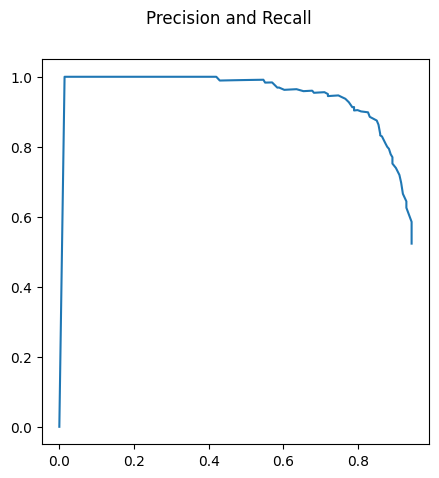

In [28]:
precision_values = []
recall_values = []

# TODO: fill precision/recall lists
for i in range(0, 100):
    precision, recall = precision_recall(all_ious, data, i / 100, 0.5)
    precision_values.append(precision)
    recall_values.append(recall)

viz = Visualizer(num_rows=1, num_cols=1, figsize=(5,5), axis_off=False, title='Precision and Recall', tight=True)
viz.add_subplot_xy(0, 0, recall_values, precision_values)


Analyse the PR curve for several IoU thresholds.
* What can you tell about our detector?

### Optional Task - overconfidence is a slow and insidious killer
Another way to analyse the quality of the confidence prediction is to plot a scatter plot using all predicted boxes. The the x-axis is the confidence, while the y-axis is the IoU with the best matching GT box. If this plot is close to a line (x=y), the confidence correlated with the expected GT box overlap.
Create this plot and draw some conclusions.

### Optional Task - Scaling up the evaluation
Download `coco_bboxes_full.json` and extend your evaluation code to handle multiple classes. Average precision and recall across all 80 classes of the COCO dataset.

## Problem 3.2 - Diffusion Models

We will now train a tiny diffusion model on the car images in CIFAR 10. The architecture is a small U-Net:

In [5]:
class Model(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super().__init__()
        self.down_layers = torch.nn.ModuleList([
            nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
        ])
        self.up_layers = torch.nn.ModuleList([
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.Conv2d(128, 32, kernel_size=5, padding=2),
            nn.Conv2d(64, 32, kernel_size=5, padding=2),
        ])
        self.final_conv1 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.final_conv2 = nn.Conv2d(16, out_channels, kernel_size=3, padding=1)
        self.act = nn.LeakyReLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x, timestep):
        skips = []
        for i, layer in enumerate(self.down_layers):
            x = self.act(layer(x))
            if i < 2:
              skips.append(x)
              x = self.downscale(x)

        for i, layer in enumerate(self.up_layers):
            if i > 0:
              x = self.upscale(x)
              x = torch.concatenate( [x, skips.pop()], axis=1)
            x = self.act(layer(x))

        x = self.act(self.final_conv1(x))
        x = self.final_conv2(x)
        return x

**Task:** Draw a diagram of the U-Net architecture to understand the connections within the network.

We will now load and filter the dataset to contain only cars (class_id = 1). You can use `torch.utils.data.Subset` to obtain a subset of a dataset.

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# TODO: filter training imgs
car_indices = [i for i, (_, label) in enumerate(cifar_train) if label == 1]
cifar_train_reduced = torch.utils.data.Subset(cifar_train, car_indices)

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(cifar_train_reduced, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 38.6MB/s]


We will now need to compute a noise schedule. We will precompute the schedule and some useful values to reuse them later.
There are three parameters we will get to define the schedule $\beta_1, \beta_2$ and $T$.
$T$ is the number of steps (we will use 1000)
$\beta_1$ and $\beta_2$ define the start and end of th enoise schedule.

Define a vector $\beta_t$ for $t \in \{ 0, T \} that starts with $\beta_1$ and ends with $\beta_2$. Make sure that $\beta_t = \beta_1$ for $t=0$ and $\beta_t = \beta_2$ for $t=T$. ($T+1$ values).
Also precomupte the following values:
* $\sqrt{\beta_t}$
* $\alpha_t = 1 - \beta_t$
* $\bar{\alpha}_t = \prod_{i=0}^t \alpha_i$
* $\sqrt{\bar{\alpha}_t}$
* $\frac{1}{\sqrt{\alpha_t}}$
* $\sqrt{1 - \bar{\alpha}_t}$
* $\frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}$

Then use the following formula to show examples of an image being noise through forward diffusion: $ x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$, where $\epsilon \sim \mathcal{N}(0,1)$.

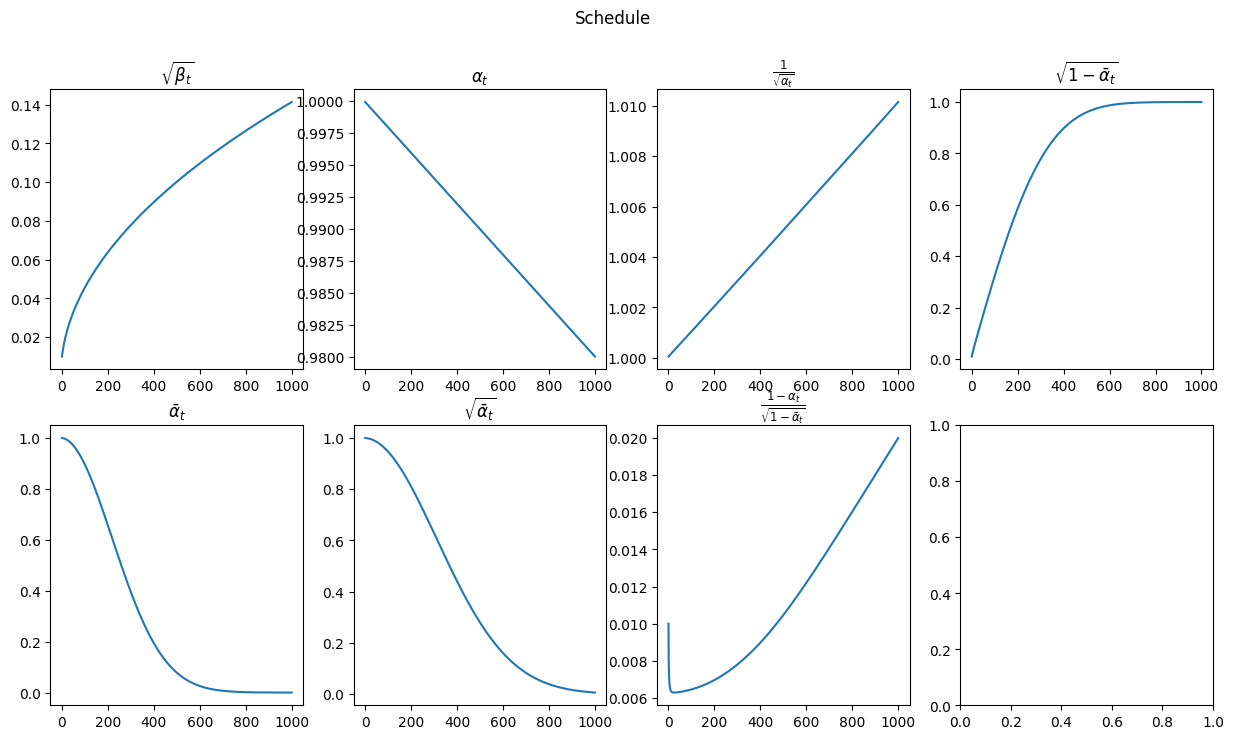

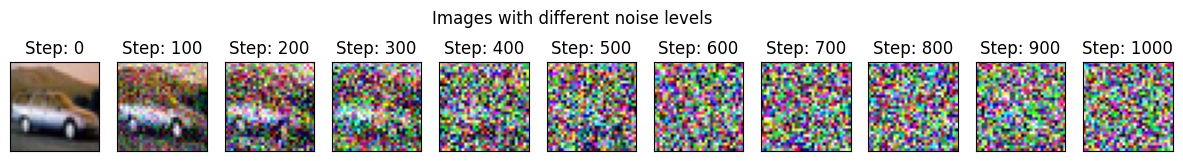

In [7]:
class Schedule():
    def __init__(self, beta1, beta2, T, device="cpu"):
        super().__init__()
        self.device = device
        self.num_steps = T

        # TODO: create torch vectors containing values for all timesteps
        # Hint: use torch.arange(0, T + 1, dtype=torch.float32, device=device) / T to create the betas

        # Create t = [0, 1, ..., T] as floats
        t = torch.arange(0, T + 1, dtype=torch.float32, device=device)

        # β_t linearly interpolating between β1 and β2
        # t / T runs from 0 → 1
        beta_t = beta1 + (beta2 - beta1) * (t / T)

        # Precompute all required terms
        self.sqrt_beta_t = torch.sqrt(beta_t)                       # √β_t
        self.alpha_t = 1.0 - beta_t                                 # α_t

        # ᾱ_t = cumulative product of α_t
        # torch.cumprod: cumulative product along a dimension
        self.alphabar_t = torch.cumprod(self.alpha_t, dim=0)        # ᾱ_t

        self.sqrtab = torch.sqrt(self.alphabar_t)                   # √ᾱ_t
        self.oneover_sqrta = 1.0 / torch.sqrt(self.alpha_t)         # 1 / √α_t
        self.sqrtmab = torch.sqrt(1.0 - self.alphabar_t)            # √(1 − ᾱ_t)

        # (1 − α_t) / √(1 − ᾱ_t)
        # This is used in posterior (reverse diffusion)
        self.mab_over_sqrtmab_inv = (1.0 - self.alpha_t) / (self.sqrtmab + 1e-8)


# show images with different noise levels
schedule = Schedule(1e-4, 0.02, 1000)

# plot the schedule
vis = Visualizer(num_rows=2, num_cols=4, figsize=(15, 8), axis_off=False, title='Schedule')
vis.add_subplot(0, 0, schedule.sqrt_beta_t, title_str=r'$\sqrt{\beta_t}$')
vis.add_subplot(0, 1, schedule.alpha_t, title_str=r'$\alpha_t$')
vis.add_subplot(1, 0, schedule.alphabar_t, title_str=r'$\bar{\alpha}_t$')
vis.add_subplot(1, 1, schedule.sqrtab, title_str=r'$\sqrt{\bar{\alpha}_t}$')
vis.add_subplot(0, 2, schedule.oneover_sqrta, title_str=r'$\frac{1}{\sqrt{\alpha_t}}$')
vis.add_subplot(0, 3, schedule.sqrtmab, title_str=r'$\sqrt{1 - \bar{\alpha}_t}$')
vis.add_subplot(1, 2, schedule.mab_over_sqrtmab_inv, title_str=r'$\frac{1 - \alpha_t}{\sqrt{1 - \bar{\alpha}_t}}$')

vis = Visualizer(num_rows=1, num_cols=11, figsize=(15, 2), axis_off=True, title='Images with different noise levels')
for i in range(11):
    img, _ = cifar_train_reduced[0]
    noise = torch.randn(img.shape)
    step = i * (schedule.num_steps // 10)

    # TODO: compute noised sample
    sqrt_alphabar_t = schedule.sqrtab[step]
    sqrt_one_minus_alphabar_t = schedule.sqrtmab[step]
    img = sqrt_alphabar_t * img + sqrt_one_minus_alphabar_t * noise

    # normalise for display
    img = (img + 1) / 2
    img = img.clip(0, 1)
    img = img.permute(1, 2, 0)
    vis.add_image_subplot(0, i, img.numpy(), title_str=f'Step: {step}')

We now need a function that given a batch of images and timesteps, produces input-output pairs. Each input will be noised with the corresponding timestep, while the target should be the corresponding noise. Make sure that the returned vector of timesteps is a float32.

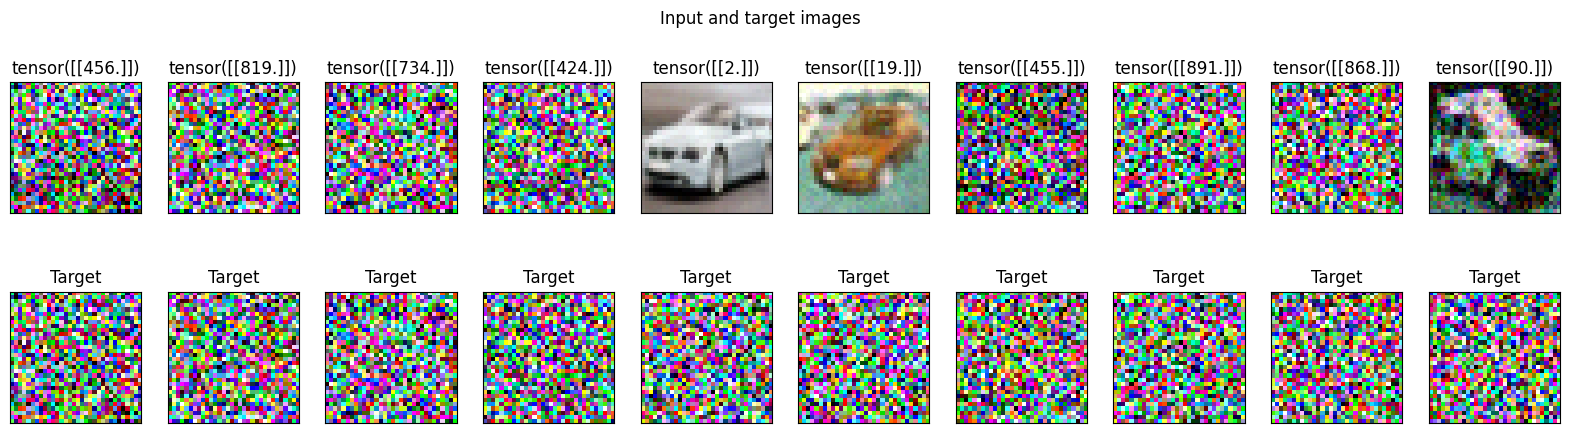

In [11]:
def generate_input_target(batch, schedule):
    B = batch.shape[0]

    # Sample random timesteps for each image
    timesteps = torch.randint(
        low=0,
        high=schedule.num_steps + 1,
        size=(B, 1, 1, 1),   # broadcastable shape
        device=batch.device
    ).float()               # must be float32

    # Extract √ᾱ_t and √(1−ᾱ_t) for each selected timestep
    sqrt_ab = schedule.sqrtab[timesteps.long()].to(batch.device)          # (B,1,1,1)
    sqrt_mab = schedule.sqrtmab[timesteps.long()].to(batch.device)        # (B,1,1,1)

    # Generate noise
    noise = torch.randn_like(batch)

    # Forward diffusion: x_t = √ᾱ_t x_0 + √(1−ᾱ_t) ε
    batch = sqrt_ab * batch + sqrt_mab * noise

    return batch, noise, timesteps

# visualise 4 input and target images
vis = Visualizer(num_rows=2, num_cols=10, figsize=(20, 5), axis_off=True, title='Input and target images')
batch, _ = next(iter(train_loader))
input_imgs, targets, timesteps = generate_input_target(batch, schedule)

input_imgs = (input_imgs*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
targets = (targets*0.5+0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)

for i in range(10):
    vis.add_image_subplot(0, i, input_imgs[i], title_str=f'{timesteps[i,0]}')
    vis.add_image_subplot(1, i, targets[i], title_str=f'Target')


We will first write a function to generate samples from the model that we can then use during training.
Sampling works like this:


* $x_T \sim \mathcal{N}(0,1)$
* for $t = T$ downto 1:
  * $z \sim \mathcal{N}(0,1)$ if t > 1 else 0
  * $x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{1-\alpha_t}{\sqrt{1 - \bar{\alpha}_t}}f(x_t, t) \right) + \sqrt{\beta_t}z $

Here $f(x_t, t)$ is the model. It takes as input the current sample and the timestep $t$. The loop terminates with $x_0$ which is the final sample.

We will "test" this function by running it with a randomly initialised model. This will not show us much but checks if the code at least runs :) ...


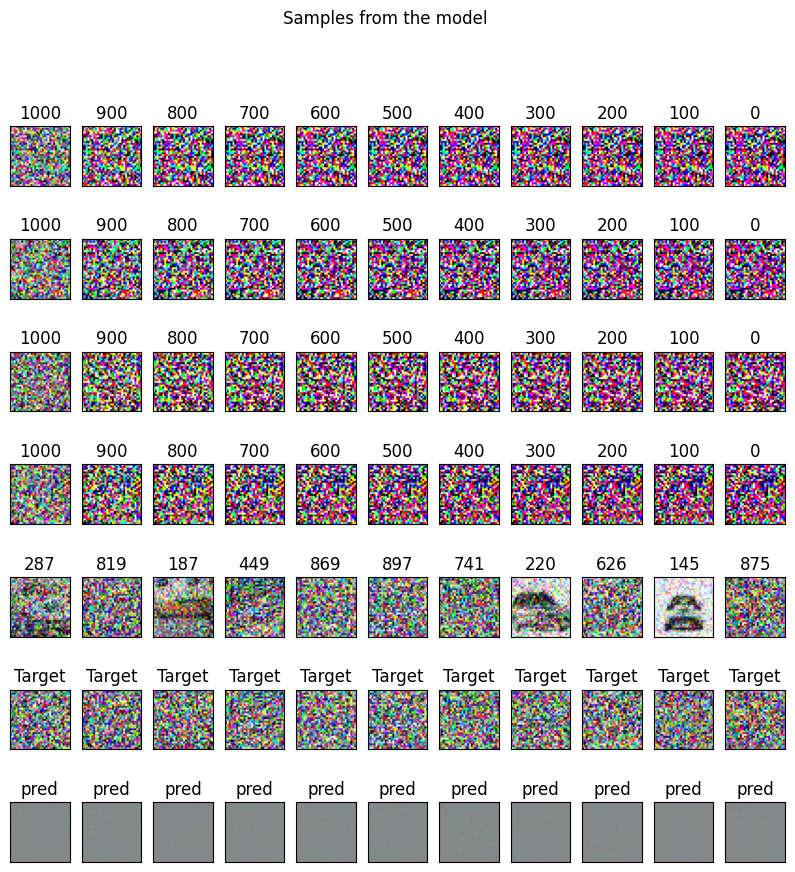

In [12]:
def sample(model, schedule):
    model.eval()
    sample = torch.randn(4, 3, 32, 32, device=schedule.device)

    vis = Visualizer(num_rows=sample.shape[0]+3, num_cols=11, figsize=(10, 10), axis_off=True, title='Samples from the model')
    with torch.no_grad():
        for i in tqdm(range(schedule.num_steps, 0, -1)):
            # TODO: compute sample
            # Predict noise
            eps_theta = model(sample, torch.full((sample.shape[0], 1, 1, 1),
                                        i, device=sample.device, dtype=torch.float32))

            # Get schedule coefficients for timestep i
            one_over_sqrta = schedule.oneover_sqrta[i]                  # 1/sqrt(alpha_t)
            mab_over_sqrtmab = schedule.mab_over_sqrtmab_inv[i]         # (1 - alpha_t) / sqrt(1 - alphabar_t)
            sqrt_beta_t = schedule.sqrt_beta_t[i]                       # sqrt(beta_t)

            # Compute x_{t-1}
            sample = one_over_sqrta * (
                sample - mab_over_sqrtmab * eps_theta
            )

            # Add noise except at last step
            if i > 1:
                sample += sqrt_beta_t * torch.randn_like(sample)
            # plotting
            if i % (schedule.num_steps // 10) == 0:
                img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
                for j in range(sample.shape[0]):
                    vis.add_image_subplot(j, 10 - i//(schedule.num_steps // 10), img[j], title_str=f'{i}')

    # plot the final sample
    img = (sample*0.5 + 0.5).clip(0,1).cpu().numpy().transpose(0, 2, 3, 1)
    for j in range(sample.shape[0]):
        vis.add_image_subplot(j, 10, img[j], title_str=f'{0}')

    # also show input-target-prediction triplets
    batch, _ = next(iter(train_loader))
    input_imgs, targets, timesteps = generate_input_target(batch.to(schedule.device), schedule)
    with torch.no_grad():
        pred = model(input_imgs, timesteps)
    input_imgs = (input_imgs*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    targets = (targets*0.5+0.5).clip(0,1).detach().cpu().numpy().transpose(0, 2, 3, 1)
    pred = (pred*0.5+0.5).clip(0,1).cpu().detach().numpy().transpose(0, 2, 3, 1)
    for i in range(11):
        vis.add_image_subplot(sample.shape[0]+0, i, input_imgs[i], title_str=f'{int(timesteps[i,0])}')
        vis.add_image_subplot(sample.shape[0]+1, i, targets[i], title_str=f'Target')
        vis.add_image_subplot(sample.shape[0]+2, i, pred[i], title_str=f'pred')
    vis.show()

sample(Model(), Schedule(1e-4, 0.02, 1000))

Finally, we can write a training loop over multiple epochs.
We sample a batch from the dataloader and pass it to `generate_input_target` to get noised images and their corresponding noise targets.
We train the model simply with a squared loss on pixel intensities: $\| \epsilon_t - f(x_t, t) \|_2^2$.
You will need to train this model for about 500 epochs before the samples start to look like anything. Our network is too small to learn a _great_ diffusion model, but you should see some samples that resemble cars.
If possible, connect to a GPU runtime: Edit -> Notebook Settings -> T4 GPU.

In [15]:
device="cuda:0"  # use "cpu" or "cuda:0"
model = Model().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000)  # this will slowly decrease the learning rate for stabilty
schedule = Schedule(1e-4, 0.02, 1000, device)

epoch_losses = []
for epoch in range(1000):
    losses = []
    model.train()
    for batch, _ in tqdm(train_loader):
        batch = batch.to(device)

        # TODO: compute targets, and loss
        x_t, eps_true, timesteps = generate_input_target(batch, schedule)
        eps_pred = model(x_t, timesteps)
        loss = torch.nn.functional.mse_loss(eps_pred, eps_true)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    lr_scheduler.step()
    model.eval()
    print(f'Epoch: {epoch} - Loss: {np.mean(losses):.4f}')
    if epoch % 25 == 0:
        sample(model, schedule)


print('Training finished')
sample(model, schedule)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

### Optional Task - Classy Diffusion
Train a class-conditional model: the model takes the class of a sample as additional input. The easiest way to do that is to change the number of input channels from 3 to 3+10. This means you need to concatenate a "one-hot" 10 channel image (where the channels of the corresponding class is all 1s and all other channels are 0). The output of the model remails a 3 channel image.